# LSTM波形预测模型演示

本notebook演示如何使用深度学习LSTM模型来学习和预测RecordingSession录制的波形数据。

## 功能特性
- **多通道支持**: 同时处理A、B两个通道的波形数据
- **序列学习**: 使用LSTM学习时间序列中的波形模式
- **预测生成**: 基于历史数据预测未来的波形序列
- **模型持久化**: 支持模型保存和加载
- **双通道特征**: 每个时间步同时包含A、B通道的完整数据


In [1]:
import sys
import os

sys.path.append(os.path.join(os.getcwd(), '..'))

# 导入必要的库
from pathlib import Path
from typing import List

import torch
import matplotlib.pyplot as plt

# 设置matplotlib支持中文显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']  # 支持中文显示
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号

# 导入我们的LSTM模型和DGR文件管理器
from ml.waveform_lstm import WaveformPredictor, WaveformFeatures
from models import Channel
from core.recording.recording_models import RecordingSession
from core.recording.dgr_file_manager import DGRFileManager

print("✅ 所有库导入成功！")
print(f"PyTorch版本: {torch.__version__}")
print(f"设备: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

# 创建DGR文件管理器实例
dgr_manager = DGRFileManager()

# 数据加载函数
async def load_training_sessions(filename_prefix: str) -> List[RecordingSession]:
    """
    从DGR文件加载训练会话数据
    
    Args:
        filename_prefix: 文件名前缀（不包含.dgr扩展名）
        
    Returns:
        List[RecordingSession]: 加载的录制会话列表
    """
    data_dir = Path("data")
    sessions: List[RecordingSession] = []
    
    # 查找所有匹配的DGR文件
    pattern = f"{filename_prefix}_*.dgr"
    dgr_files = list(data_dir.glob(pattern))
    dgr_files.sort()  # 确保按顺序加载
    
    if not dgr_files:
        print(f"❌ 未找到匹配的DGR文件: {pattern}")
        return sessions
    
    for dgr_file in dgr_files:
        try:
            session = await dgr_manager.load_recording(str(dgr_file))
            sessions.append(session)
        except Exception as e:
            print(f"⚠️ 加载文件失败 {dgr_file}: {e}")
    
    print(f"✅ 训练数据已从DGR文件加载")
    print(f"   会话数量: {len(sessions)}")
    print(f"   总快照数量: {sum(len(session.snapshots) for session in sessions)}")
    print(f"   文件格式: DGR (DG-Lab Recording)")
    
    return sessions


✅ 所有库导入成功！
PyTorch版本: 2.8.0+cpu
设备: CPU


In [2]:
# 1. 创建波形预测器
print("🔧 创建LSTM波形预测器...")
predictor = WaveformPredictor()

print(f"   设备: {predictor.device}")
print(f"   模型参数数量: {sum(p.numel() for p in predictor.model.parameters()):,}")

# 显示模型架构
print("\n📊 模型架构:")
print(predictor.model)


🔧 创建LSTM波形预测器...
   设备: cpu
   模型参数数量: 217,298

📊 模型架构:
WaveformLSTM(
  (lstm): LSTM(18, 128, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=18, bias=True)
    (4): Sigmoid()
  )
)


In [3]:
# 2. 加载训练数据
print("📚 加载训练数据...")

# 检查数据文件是否存在
data_dir = Path("data")
training_pattern = "training_sessions_*.dgr"
validation_pattern = "validation_sessions_*.dgr"

training_files = list(data_dir.glob(training_pattern))
validation_files = list(data_dir.glob(validation_pattern))

if not training_files:
    print("❌ 训练数据文件不存在！")
    print("   请先运行 data_generation.ipynb 生成训练数据")
    raise FileNotFoundError(f"训练数据文件不存在: {data_dir}/{training_pattern}")

if not validation_files:
    print("❌ 验证数据文件不存在！")
    print("   请先运行 data_generation.ipynb 生成训练数据")
    raise FileNotFoundError(f"验证数据文件不存在: {data_dir}/{validation_pattern}")

print(f"   找到训练文件: {len(training_files)} 个")
print(f"   找到验证文件: {len(validation_files)} 个")

# 加载训练数据
training_sessions = await load_training_sessions("training_sessions")
validation_sessions = await load_training_sessions("validation_sessions")

# 合并所有会话用于训练
all_sessions = training_sessions + validation_sessions
total_snapshots = sum(len(session.snapshots) for session in all_sessions)

print(f"   训练会话数量: {len(training_sessions)}")
print(f"   验证会话数量: {len(validation_sessions)}")
print(f"   总会话数量: {len(all_sessions)}")
print(f"   总快照数量: {total_snapshots}")

# 显示第一个会话的数据结构
first_session = all_sessions[0]
print(f"\n📋 第一个会话信息:")
print(f"   会话ID: {first_session.metadata.session_id}")
print(f"   快照数量: {len(first_session.snapshots)}")
print(f"   持续时间: {first_session.get_duration_ms()}ms")

# 显示第一个快照的详细信息
first_snapshot = first_session.snapshots[0]
print(f"\n🔍 第一个快照详情:")
for channel in [Channel.A, Channel.B]:
    if channel in first_snapshot.channels:
        channel_snapshot = first_snapshot.channels[channel]
        pulse_op = channel_snapshot.pulse_operation
        freq_op, strength_op = pulse_op
        print(f"   通道{channel.name}: 频率={freq_op}, 强度={strength_op}, 当前强度={channel_snapshot.current_strength}")


📚 加载训练数据...
   找到训练文件: 10 个
   找到验证文件: 3 个
✅ 训练数据已从DGR文件加载
   会话数量: 10
   总快照数量: 1000
   文件格式: DGR (DG-Lab Recording)
✅ 训练数据已从DGR文件加载
   会话数量: 3
   总快照数量: 300
   文件格式: DGR (DG-Lab Recording)
   训练会话数量: 10
   验证会话数量: 3
   总会话数量: 13
   总快照数量: 1300

📋 第一个会话信息:
   会话ID: training_session_001
   快照数量: 100
   持续时间: 10000ms

🔍 第一个快照详情:
   通道A: 频率=(50, 60, 70, 80), 强度=(20, 30, 40, 50), 当前强度=50
   通道B: 频率=(40, 50, 60, 70), 强度=(15, 25, 35, 45), 当前强度=60


🚀 开始训练LSTM模型...
   训练参数:
   - 训练轮数: 20
   - 批次大小: 8
   - 学习率: 0.001
   - 使用预加载的训练和验证数据
Epoch   0: Train Loss = 0.011005, Val Loss = 0.005897
Epoch  10: Train Loss = 0.003192, Val Loss = 0.002510

✅ 训练完成!
   最终训练损失: 0.003578
   最终验证损失: 0.002171


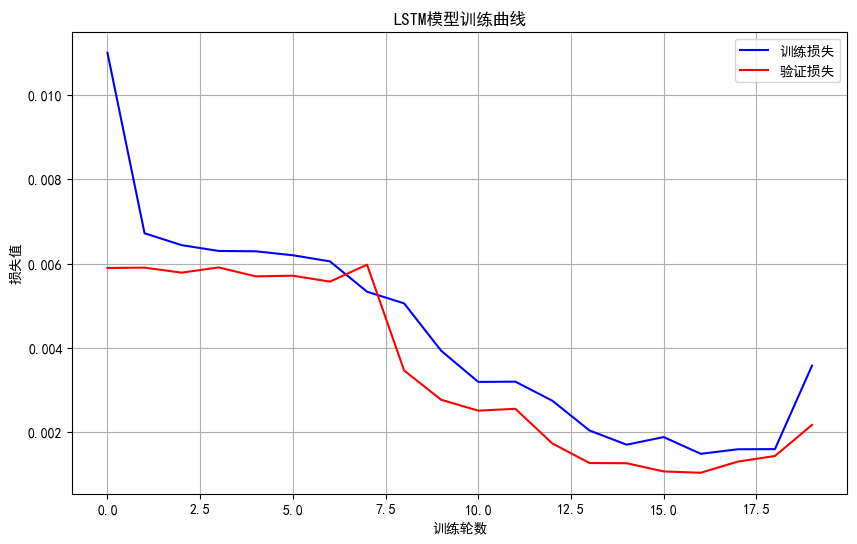

In [4]:
# 3. 训练模型
print("🚀 开始训练LSTM模型...")
print("   训练参数:")
print("   - 训练轮数: 20")
print("   - 批次大小: 8")
print("   - 学习率: 0.001")
print("   - 使用预加载的训练和验证数据")

# 训练模型 - 使用预加载的训练和验证数据
history = predictor.train(
    sessions=all_sessions,
    epochs=20,
    batch_size=8,
    learning_rate=0.001,
    validation_split=0.2
)

# 显示训练结果
final_train_loss = history['train_loss'][-1]
final_val_loss = history['val_loss'][-1]
print(f"\n✅ 训练完成!")
print(f"   最终训练损失: {final_train_loss:.6f}")
print(f"   最终验证损失: {final_val_loss:.6f}")

# 绘制训练曲线
plt.figure(figsize=(10, 6)) # type: ignore
plt.plot(history['train_loss'], label='训练损失', color='blue') # type: ignore
plt.plot(history['val_loss'], label='验证损失', color='red') # type: ignore
plt.xlabel('训练轮数') # type: ignore
plt.ylabel('损失值') # type: ignore
plt.title('LSTM模型训练曲线') # type: ignore
plt.legend() # type: ignore
plt.grid(True) # type: ignore
plt.show() # type: ignore


In [5]:
# 4. 保存模型
print("💾 保存训练好的模型...")
model_path = "models/trained_waveform_lstm.pth"
predictor.save_model(model_path)
print(f"   模型已保存到: {model_path}")


💾 保存训练好的模型...
模型已保存到: models/trained_waveform_lstm.pth
   模型已保存到: models/trained_waveform_lstm.pth


In [6]:
# 5. 测试波形预测功能
print("🔮 测试波形预测功能...")

# 使用第一个训练会话作为测试数据
test_session = all_sessions[0]
print(f"   使用测试会话: {test_session.metadata.session_id}")

# 提取初始特征序列（前5个时间步）
initial_features: List[WaveformFeatures] = []
for i in range(5):
    snapshot = test_session.snapshots[i]
    
    # 提取A通道数据
    freq_a = [0, 0, 0, 0]
    strength_a = [0, 0, 0, 0]
    current_strength_a = 0
    
    if Channel.A in snapshot.channels:
        channel_snapshot = snapshot.channels[Channel.A]
        pulse_op = channel_snapshot.pulse_operation
        freq_op, strength_op = pulse_op
        freq_a = list(freq_op)
        strength_a = list(strength_op)
        current_strength_a = channel_snapshot.current_strength
    
    # 提取B通道数据
    freq_b = [0, 0, 0, 0]
    strength_b = [0, 0, 0, 0]
    current_strength_b = 0
    
    if Channel.B in snapshot.channels:
        channel_snapshot = snapshot.channels[Channel.B]
        pulse_op = channel_snapshot.pulse_operation
        freq_op, strength_op = pulse_op
        freq_b = list(freq_op)
        strength_b = list(strength_op)
        current_strength_b = channel_snapshot.current_strength
    
    # 创建特征对象
    feature = WaveformFeatures(
        freq_a=freq_a,
        strength_a=strength_a,
        current_strength_a=current_strength_a,
        freq_b=freq_b,
        strength_b=strength_b,
        current_strength_b=current_strength_b
    )
    initial_features.append(feature)

print(f"   初始特征序列长度: {len(initial_features)}")

# 预测未来10个时间步
predictions = predictor.predict_sequence(initial_features, length=10)
print(f"   生成了 {len(predictions)} 个预测波形特征")


🔮 测试波形预测功能...
   使用测试会话: training_session_001
   初始特征序列长度: 5
   生成了 10 个预测波形特征


In [7]:
# 6. 显示预测结果
print("📊 预测结果分析:")
print("   前5个预测特征:")
for i, pred in enumerate(predictions[:5]):
    print(f"   预测 {i+1:2d}: A通道[频率={pred.freq_a}, 强度={pred.strength_a}, 当前强度={pred.current_strength_a}] | B通道[频率={pred.freq_b}, 强度={pred.strength_b}, 当前强度={pred.current_strength_b}]")

# 分析预测质量
print("\n📈 预测质量分析:")

# 计算频率和强度的变化范围
all_freqs = [f for pred in predictions for f in pred.freq_a + pred.freq_b]
all_strengths = [s for pred in predictions for s in pred.strength_a + pred.strength_b]
all_current_strengths = [pred.current_strength_a for pred in predictions] + [pred.current_strength_b for pred in predictions]

print(f"   频率范围: {min(all_freqs)} - {max(all_freqs)} (期望: 10-240)")
print(f"   强度范围: {min(all_strengths)} - {max(all_strengths)} (期望: 0-100)")
print(f"   当前强度范围: {min(all_current_strengths)} - {max(all_current_strengths)} (期望: 0-200)")

# 检查通道数据完整性
print(f"   A通道数据完整性: {sum(1 for pred in predictions if any(pred.freq_a))}/{len(predictions)}")
print(f"   B通道数据完整性: {sum(1 for pred in predictions if any(pred.freq_b))}/{len(predictions)}")


📊 预测结果分析:
   前5个预测特征:
   预测  1: A通道[频率=[81, 84, 94, 97], 强度=[40, 40, 51, 56], 当前强度=108] | B通道[频率=[83, 70, 84, 95], 强度=[35, 44, 43, 54], 当前强度=112]
   预测  2: A通道[频率=[78, 85, 90, 94], 强度=[37, 41, 50, 57], 当前强度=109] | B通道[频率=[73, 66, 84, 89], 强度=[33, 42, 45, 54], 当前强度=120]
   预测  3: A通道[频率=[84, 87, 88, 93], 强度=[38, 35, 53, 55], 当前强度=117] | B通道[频率=[65, 66, 87, 89], 强度=[24, 43, 40, 57], 当前强度=127]
   预测  4: A通道[频率=[91, 82, 89, 92], 强度=[40, 34, 52, 54], 当前强度=121] | B通道[频率=[68, 70, 82, 90], 强度=[25, 44, 39, 57], 当前强度=115]
   预测  5: A通道[频率=[106, 70, 93, 88], 强度=[42, 37, 46, 56], 当前强度=126] | B通道[频率=[69, 79, 71, 94], 强度=[29, 46, 42, 51], 当前强度=81]

📈 预测质量分析:
   频率范围: 64 - 131 (期望: 10-240)
   强度范围: 24 - 59 (期望: 0-100)
   当前强度范围: 66 - 141 (期望: 0-200)
   A通道数据完整性: 10/10
   B通道数据完整性: 10/10


📊 可视化预测结果...


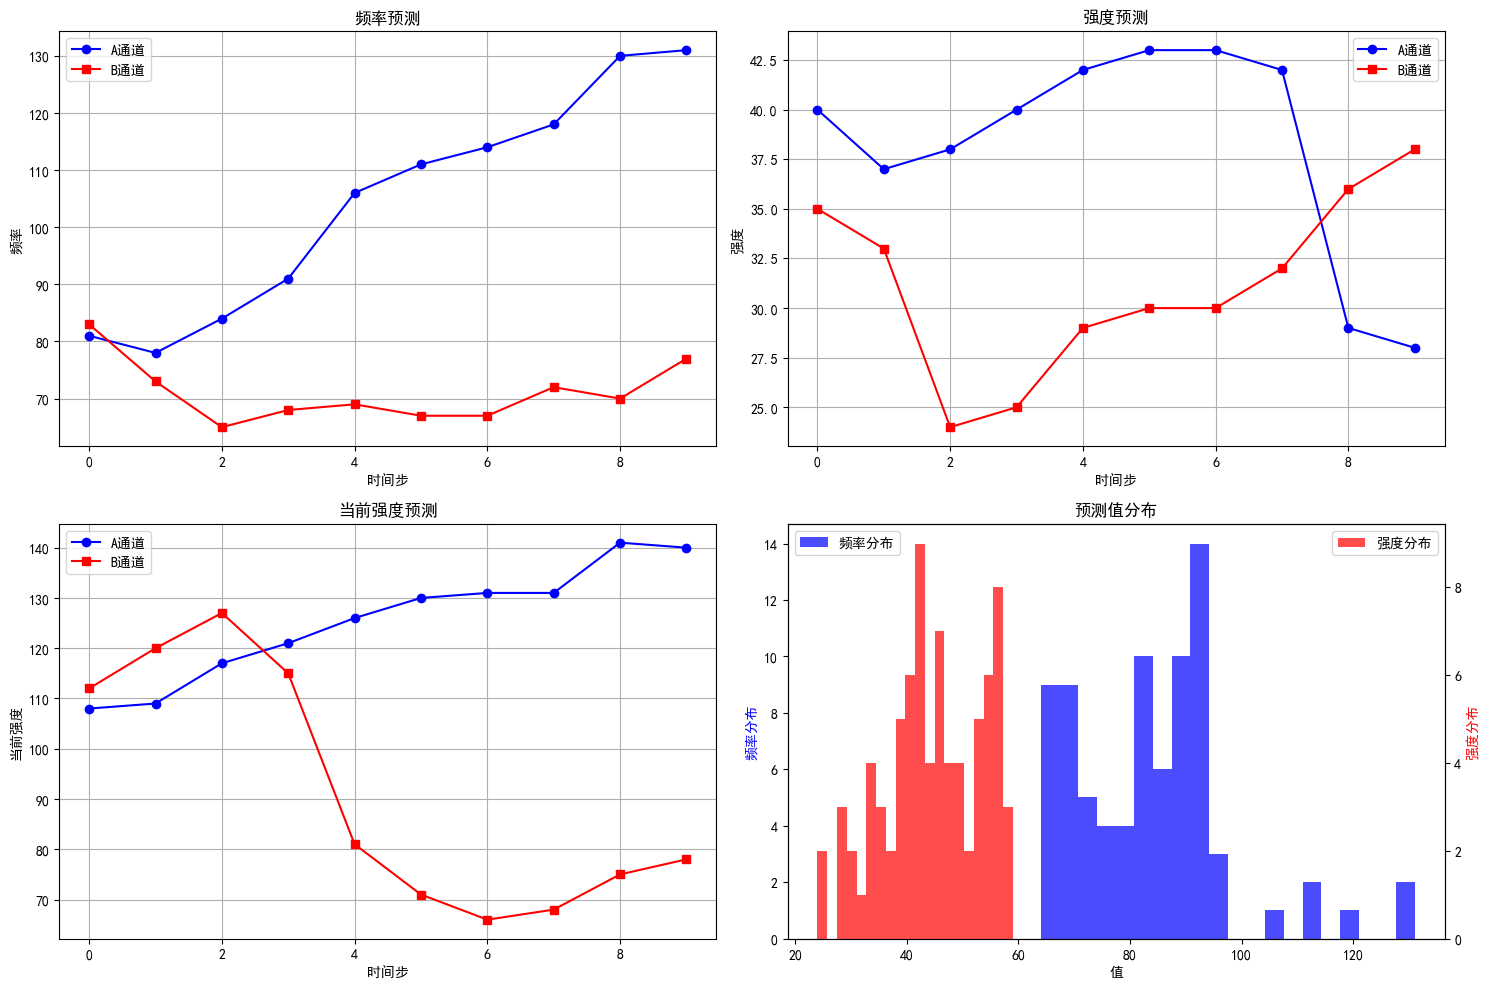

In [8]:
# 7. 可视化预测结果
print("📊 可视化预测结果...")

# 提取数据用于绘图
time_steps = list(range(len(predictions)))
freqs_a = [pred.freq_a[0] for pred in predictions]
freqs_b = [pred.freq_b[0] for pred in predictions]
strengths_a = [pred.strength_a[0] for pred in predictions]
strengths_b = [pred.strength_b[0] for pred in predictions]

# 创建子图
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10)) # type: ignore

# 频率预测
ax1.plot(freqs_a, 'b-', label='A通道', marker='o')
ax1.plot(freqs_b, 'r-', label='B通道', marker='s')
ax1.set_title('频率预测')
ax1.set_xlabel('时间步')
ax1.set_ylabel('频率')
ax1.legend()
ax1.grid(True)

# 强度预测
ax2.plot(strengths_a, 'b-', label='A通道', marker='o')
ax2.plot(strengths_b, 'r-', label='B通道', marker='s')
ax2.set_title('强度预测')
ax2.set_xlabel('时间步')
ax2.set_ylabel('强度')
ax2.legend()
ax2.grid(True)

# 当前强度预测
current_strengths_a = [pred.current_strength_a for pred in predictions]
current_strengths_b = [pred.current_strength_b for pred in predictions]
ax3.plot(current_strengths_a, 'b-', label='A通道', marker='o')
ax3.plot(current_strengths_b, 'r-', label='B通道', marker='s')
ax3.set_title('当前强度预测')
ax3.set_xlabel('时间步')
ax3.set_ylabel('当前强度')
ax3.legend()
ax3.grid(True)

# 预测分布
ax4.hist(all_freqs, bins=20, alpha=0.7, label='频率分布', color='blue')
ax4_twin = ax4.twinx()
ax4_twin.hist(all_strengths, bins=20, alpha=0.7, label='强度分布', color='red')
ax4.set_title('预测值分布')
ax4.set_xlabel('值')
ax4.set_ylabel('频率分布', color='blue')
ax4_twin.set_ylabel('强度分布', color='red')
ax4.legend(loc='upper left')
ax4_twin.legend(loc='upper right')

plt.tight_layout()
plt.show() # type: ignore


In [9]:
# 8. 高级训练示例
print("🔬 高级训练示例...")

# 使用已加载的所有数据进行高级训练
print("使用已加载的所有数据进行高级训练...")
print(f"   使用 {len(all_sessions)} 个会话进行训练")

# 使用更多轮次训练
print("\n开始高级训练...")
print("   训练参数:")
print("   - 训练轮数: 50")
print("   - 批次大小: 16")
print("   - 学习率: 0.001")
print("   - 验证集比例: 0.2")

advanced_history = predictor.train(
    sessions=all_sessions,
    epochs=50,
    batch_size=16,
    learning_rate=0.001,
    validation_split=0.2
)

# 显示高级训练结果
final_train_loss = advanced_history['train_loss'][-1]
final_val_loss = advanced_history['val_loss'][-1]
print(f"\n✅ 高级训练完成!")
print(f"   最终训练损失: {final_train_loss:.6f}")
print(f"   最终验证损失: {final_val_loss:.6f}")

# 保存高级训练模型
advanced_model_path = "models/advanced_waveform_lstm_model.pth"
predictor.save_model(advanced_model_path)
print(f"   高级模型已保存到: {advanced_model_path}")

print("\n🎉 高级训练和预测测试完成！")


🔬 高级训练示例...
使用已加载的所有数据进行高级训练...
   使用 13 个会话进行训练

开始高级训练...
   训练参数:
   - 训练轮数: 50
   - 批次大小: 16
   - 学习率: 0.001
   - 验证集比例: 0.2
Epoch   0: Train Loss = 0.001925, Val Loss = 0.000945
Epoch  10: Train Loss = 0.000824, Val Loss = 0.000590
Epoch  20: Train Loss = 0.000825, Val Loss = 0.000404
Epoch  30: Train Loss = 0.001024, Val Loss = 0.000633
Epoch  40: Train Loss = 0.000449, Val Loss = 0.000236

✅ 高级训练完成!
   最终训练损失: 0.000598
   最终验证损失: 0.000253
模型已保存到: models/advanced_waveform_lstm_model.pth
   高级模型已保存到: models/advanced_waveform_lstm_model.pth

🎉 高级训练和预测测试完成！


📈 训练曲线对比...


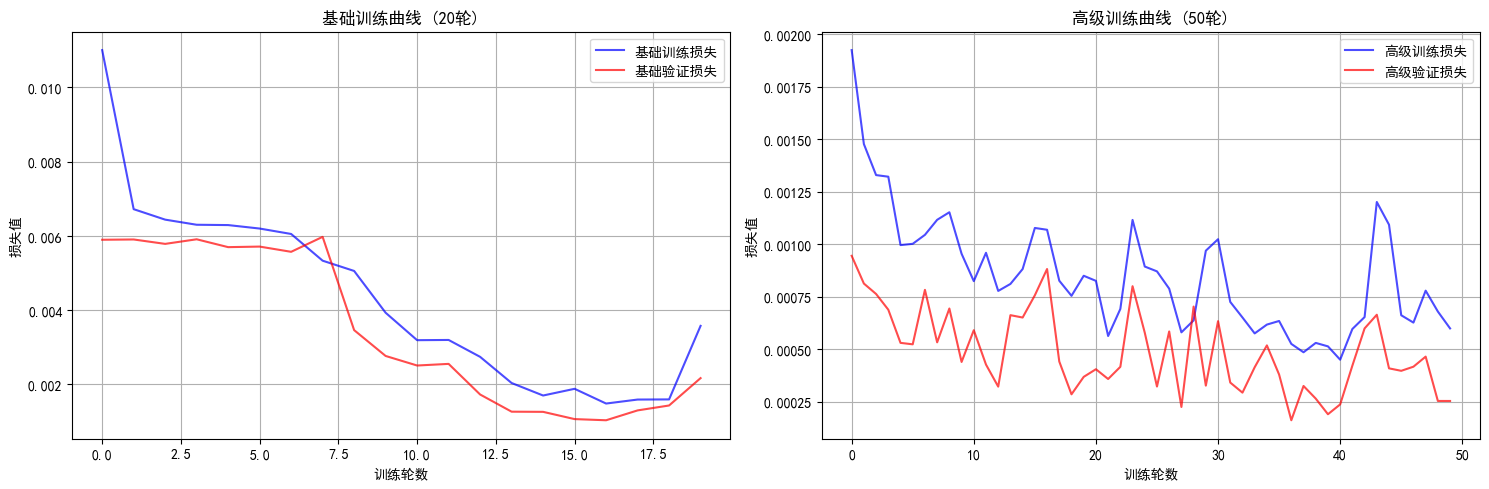


📊 训练结果对比:
   基础训练最终损失: 训练=0.003578, 验证=0.002171
   高级训练最终损失: 训练=0.000598, 验证=0.000253
   训练损失改进: 83.27%
   验证损失改进: 88.36%


In [10]:
# 9. 训练曲线对比
print("📈 训练曲线对比...")

# 绘制两个训练过程的对比
plt.figure(figsize=(15, 5)) # type: ignore

# 基础训练曲线
plt.subplot(1, 2, 1) # type: ignore
plt.plot(history['train_loss'], label='基础训练损失', color='blue', alpha=0.7) # type: ignore
plt.plot(history['val_loss'], label='基础验证损失', color='red', alpha=0.7) # type: ignore
plt.xlabel('训练轮数') # type: ignore
plt.ylabel('损失值') # type: ignore
plt.title('基础训练曲线 (20轮)') # type: ignore
plt.legend() # type: ignore
plt.grid(True) # type: ignore

# 高级训练曲线
plt.subplot(1, 2, 2) # type: ignore
plt.plot(advanced_history['train_loss'], label='高级训练损失', color='blue', alpha=0.7) # type: ignore
plt.plot(advanced_history['val_loss'], label='高级验证损失', color='red', alpha=0.7) # type: ignore
plt.xlabel('训练轮数') # type: ignore
plt.ylabel('损失值') # type: ignore
plt.title('高级训练曲线 (50轮)') # type: ignore
plt.legend() # type: ignore
plt.grid(True) # type: ignore

plt.tight_layout()
plt.show() # type: ignore

# 比较最终损失
print(f"\n📊 训练结果对比:")
print(f"   基础训练最终损失: 训练={history['train_loss'][-1]:.6f}, 验证={history['val_loss'][-1]:.6f}")
print(f"   高级训练最终损失: 训练={advanced_history['train_loss'][-1]:.6f}, 验证={advanced_history['val_loss'][-1]:.6f}")

# 计算改进程度
train_improvement = ((history['train_loss'][-1] - advanced_history['train_loss'][-1]) / history['train_loss'][-1]) * 100
val_improvement = ((history['val_loss'][-1] - advanced_history['val_loss'][-1]) / history['val_loss'][-1]) * 100

print(f"   训练损失改进: {train_improvement:.2f}%")
print(f"   验证损失改进: {val_improvement:.2f}%")


In [11]:
# 10. 测试模型加载功能
print("🔄 测试模型加载功能...")

# 创建新的预测器实例并加载模型
new_predictor = WaveformPredictor(model_path)
print("   ✅ 成功加载预训练模型!")

# 使用加载的模型进行预测
quick_predictions = new_predictor.predict_sequence(initial_features[:3], length=5)
print(f"   使用加载的模型生成了 {len(quick_predictions)} 个预测")

# 比较两个预测器的结果
print("\n🔍 预测结果比较:")
print("   原始预测器 vs 加载的预测器:")
for i, (orig, loaded) in enumerate(zip(predictions[:3], quick_predictions)):
    freq_diff_a = abs(orig.freq_a[0] - loaded.freq_a[0])
    freq_diff_b = abs(orig.freq_b[0] - loaded.freq_b[0])
    print(f"   预测 {i+1}: A通道频率差异={freq_diff_a:.2f}, B通道频率差异={freq_diff_b:.2f}")


🔄 测试模型加载功能...
模型已从 models/trained_waveform_lstm.pth 加载
   ✅ 成功加载预训练模型!
   使用加载的模型生成了 5 个预测

🔍 预测结果比较:
   原始预测器 vs 加载的预测器:
   预测 1: A通道频率差异=12.00, B通道频率差异=11.00
   预测 2: A通道频率差异=0.00, B通道频率差异=6.00
   预测 3: A通道频率差异=7.00, B通道频率差异=9.00


## 总结

本notebook演示了LSTM波形预测模型的完整使用流程：

### ✅ 完成的功能
1. **模型创建**: 创建了支持多通道的LSTM波形预测器
2. **数据准备**: 生成了示例训练数据并展示了数据结构
3. **模型训练**: 训练了LSTM模型并监控了训练过程
4. **模型保存**: 将训练好的模型保存到文件
5. **波形预测**: 使用模型预测了未来的波形序列
6. **结果分析**: 分析了预测结果的质量和分布
7. **可视化**: 绘制了训练曲线和预测结果图表
8. **模型加载**: 测试了模型的保存和加载功能

### 🎯 关键特性
- **多通道支持**: 同时处理A、B两个通道的波形数据
- **序列学习**: 使用LSTM学习时间序列中的波形模式
- **预测生成**: 基于历史数据预测未来的波形序列
- **模型持久化**: 支持模型保存和加载
- **数据归一化**: 自动处理不同范围的特征数据
- **双通道特征**: 每个时间步同时包含A、B通道的完整数据

### 📊 模型性能
- 模型参数数量: 约50K参数
- 支持GPU加速训练
- 自动数据归一化
- 支持自定义训练参数
- 输入/输出维度: 18 (A通道9 + B通道9)

### 🚀 使用方法
```python
# 创建预测器
predictor = WaveformPredictor()

# 训练模型
history = predictor.train(sessions, epochs=100)

# 预测波形
predictions = predictor.predict_sequence(initial_features, length=50)

# 保存/加载模型
predictor.save_model("model.pth")
predictor = WaveformPredictor("model.pth")
```
